In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
from pyqpanda import QCloud, real_chip_type, QMachineType, CPUQVM, QProg, run_with_configuration
from pyqpanda import origin_72, get_realtime_topology, topology_match, CNOT_GATE
from pyqpanda import init, qAlloc_many, cAlloc_many, create_empty_qprog, H, RX, RZ , CNOT, prob_run_dict, finalize, measure_all

%matplotlib inline

In [2]:
def cost_maxcut(bitstring, weights):
    """
    Computes the cost of a given bitstring solution for the Max-Cut problem.

    Parameters:
    bitstring (str): A binary string representing a partition of the graph nodes (e.g., "1010").
    weights (dict): A dictionary where keys are edge tuples (i, j) and values are edge weights.

    Returns:
    float: The computed cost of the Max-Cut solution.
    """
    cost = 0  # Initialize the cost
    
    # Iterate through all edges in the graph
    for i, j in weights.keys():
        # Check if the nodes i and j are in different partitions (cut condition)
        if bitstring[i] + bitstring[j] in ["10", "01"]:
            cost += weights[i, j]  # Add the edge weight to the cost

    return cost  # Return the total cut cost


def objective_MaxCut(samples_dict, G, optimal):
    """
    Evaluates the performance of a quantum algorithm for the Max-Cut problem.

    Parameters:
    samples_dict (dict): A dictionary where keys are bitstrings (binary solutions), 
                         and values are their occurrence counts.
    G (networkx.Graph): The input weighted graph where edges represent cut costs.
    optimal (str): The optimal bitstring solution found by classical solvers (e.g., CPLEX).

    Returns:
    dict: A dictionary containing:
        - "results": A numpy array with computed cost, normalized cost ratio, and counts.
        - "G": The input graph G.
        - "weights": The edge weights extracted from G.
        - "max_cut": The cost of the optimal Max-Cut solution.
        - "r": The expected approximation ratio.
        - "probability": The probability of sampling the optimal solution.
    """

    # Extract weights from the graph's edges
    weights = {(i, j): (G[i][j]["weight"] if len(G[i][j]) != 0 else 1) for i, j in G.edges}
    
    # Compute the cost of the optimal Max-Cut solution
    max_cost = cost_maxcut(optimal, weights)

    results = []  # Stores results in the form [cost, ratio, counts]
    probability = 0  # Tracks probability of sampling the optimal solution

    # Iterate through all sampled bitstrings
    for bitstring, counts in samples_dict.items():
        cost = cost_maxcut(bitstring, weights)  # Compute cost of the given bitstring
        r = cost / max_cost  # Compute the cost ratio relative to the optimal solution
        results.append([cost, r, counts])  # Store results
        
        # If this bitstring matches the optimal cost, update probability
        if abs(cost - max_cost) < 1e-6:
            probability += counts
        
        # Check if a better-than-optimal solution appears (sanity check)
        if cost > max_cost:
            print(f"There is a better cost than that of CPLEX: {cost - max_cost}")

    # Convert results to a NumPy array for easy computation
    results = np.array(results)

    # Total number of shots (total sampled solutions)
    shots = np.sum(results[:, 2])

    # Compute the expected approximation ratio: (weighted sum of costs) / (shots * max_cost)
    rT = np.sum(results[:, 0] * results[:, 2]) / (shots * max_cost)

    # Normalize the probability of sampling the optimal solution
    probability /= shots

    # Return results in a structured dictionary
    return {
        "results": np.array(results),
        "G": G,
        "weights": weights,
        "max_cut": max_cost,
        "r": rT,
        "probability": probability
    }

def mitigate(samples_dict, G, random=False):
    """
    Applies error mitigation by flipping individual bits in sampled solutions 
    to find better Max-Cut solutions.

    Parameters:
    samples_dict (dict): A dictionary where keys are bitstrings (binary solutions), 
                         and values are their occurrence counts.
    G (networkx.Graph): The input weighted graph where edges represent cut costs.
    random (bool, optional): If True, randomizes the order in which qubits are flipped.
                             Default is False (systematic flipping).

    Returns:
    dict: A dictionary of improved bitstring samples with their updated counts.
    """

    # Define a mapping to flip bits ('0' -> '1', '1' -> '0')
    change = {"0": "1", "1": "0"}

    # Get the number of nodes (qubits)
    nq = G.number_of_nodes()

    # Extract weights from the graph's edges
    weights = {(i, j): (G[i][j]["weight"] if len(G[i][j]) != 0 else 1) for i, j in G.edges}

    # Dictionary to store new (improved) samples
    new_samples = defaultdict(int)

    # Iterate over all bitstring samples
    for bitstring, counts in samples_dict.items():
        for _ in range(counts):  # Process each occurrence of the bitstring separately
            best_string = bitstring  # Initialize the best solution as the current one
            best_cost = cost_maxcut(bitstring, weights)  # Compute its cost
            
            # Create an ordered list of qubits (nodes) to consider flipping
            list_qubits = np.arange(nq)
            
            # If random flipping is enabled, shuffle the qubit order
            if random:
                np.random.shuffle(list_qubits)

            # Try flipping each qubit and check if the cost improves
            for qi in list_qubits:
                # Flip the bit at position qi
                new_string = "".join((change[i] if n == qi else i) for n, i in enumerate(best_string))
                new_cost = cost_maxcut(new_string, weights)

                # If the new configuration gives a better cost, update the best solution
                if new_cost > best_cost:
                    best_string = new_string
                    best_cost = new_cost
            
            # Store the improved bitstring in the new_samples dictionary
            new_samples[best_string] += 1

    return new_samples  # Return the mitigated samples

def random_samples(num_samples, n_qubits):
    """
    Generates random bitstring samples for a given number of qubits.

    Parameters:
    num_samples (int): The number of random bitstrings to generate.
    n_qubits (int): The number of qubits (length of each bitstring).

    Returns:
    dict: A dictionary where keys are randomly generated bitstrings 
          and values are their occurrence counts.
    """
    
    random_samples = defaultdict(int)  # Dictionary to store bitstrings and their counts

    # Generate random bitstrings and count their occurrences
    for _ in range(num_samples):
        bitstring = "".join(str(i) for i in np.random.choice([0, 1], n_qubits))  # Generate a random bitstring
        random_samples[bitstring] += 1  # Increment count for the generated bitstring

    return random_samples  # Return the dictionary of samples


In [3]:
qpu_data = get_realtime_topology(72, False)

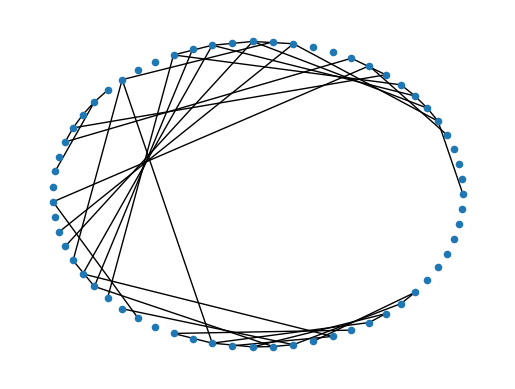

In [4]:
G_chip = nx.Graph()
qubits = qpu_data[1]
G_chip.add_nodes_from(qubits)

G_chip.add_edges_from(qpu_data[0])
fig, ax  = plt.subplots()
pos = nx.circular_layout(G_chip)

nx.draw(G_chip, ax=ax, pos =pos, node_size=20)
len_best_path = 0
for i in G_chip.nodes():
    path = [i]
    while True:
        neighbor_qubits = list(G_chip[path[-1]].keys())
        suma = 0
        for q in neighbor_qubits:
            if q not in path:
                path.append(q)
                break
            else:
                suma += 1
        if suma == len(neighbor_qubits):
            break
    if len(path) > len_best_path:
        best_path = path
        len_best_path = len(path)

results = {}
results["list_1D"] = path
results["GT"] = G_chip

In [5]:
def QAOA(G, gammas, betas, qvm):
    max_weight = max([abs(G[i][j]["weight"]) for i, j in G.edges()])
    ps = len(gammas)
    nq = G.number_of_nodes()
    layers_1 = [(i,i+1) for i in range(0, nq, 2)]
    layers_2 = [(i,i+1) for i in range(1, nq, 2)]
    prog = QProg()
    qubits = qvm.qAlloc_many(nq)
    cbits = qvm.cAlloc_many(nq)
    prog << H(qubits)
    for p in range(ps):
        for i, j in G.edges():
            if (i,j) in layers_1:
                prog << CNOT(qubits[i],qubits[j]) \
                    << RZ(qubits[j], 2 * (G[i][j]["weight"]/max_weight) * gammas[p]) \
                    << CNOT(qubits[i],qubits[j])
        for i, j in G.edges():
            if (i,j) in layers_2:
                prog << CNOT(qubits[i],qubits[j]) \
                    << RZ(qubits[j], 2 * (G[i][j]["weight"]/max_weight) * gammas[p]) \
                    << CNOT(qubits[i],qubits[j])    
        prog << RX(qubits, -2 * betas[p])
    prog << measure_all(qubits, cbits)
    return prog, qubits, cbits

In [6]:
problems = np.load("./Data/problems_1DChain.npy", allow_pickle=True).item()

In [7]:
delta_beta = 1
delta_gamma = 1

p = 10
nq = 5
G = problems["G"][nq]
sol = problems["sol"][nq]
betas = list(np.arange(1, p+1)[::-1] * delta_beta/p)  # Reverse sequence for betas
gammas = list(np.arange(1, p+1) * delta_gamma/p)  # Forward sequence for gammas
# Perform probability measurements on quantum programs


qvm = CPUQVM()
qvm.init_qvm()
program, qubits, cbits = QAOA(G, gammas, betas, qvm)
qvm.directly_run(program)

result = qvm.run_with_configuration(program, cbits, 1000)
# Print measurement results
print(result[sol[0]] + result[sol[1]])


828


# Real QPU

In [15]:
# The number of layers in the quantum circuit exceeds the limit: details for using 75 layers or more
QCM = QCloud()
with open("../origin_quantum_token.txt", "r") as r:
    token = r.read()
extra = "_2"
backend_name = "originq_wukong"

ps = [3, 4, 5, 6, 7, 8, 9, 10, 13, 15, 20]  
shots = 1000
nq = 10
G = problems["G"][nq]
results = {}
deltas = [1]
results["G"] = G
results["sols"] = problems["sol"][nq]
results["ps"] = ps
results["Deltas"] = deltas
results["shots"] = shots
programs = []
for delta in deltas:
    for p in ps:
        print(f" ------   p {p} ----------")
        QCM.init_qvm(token)
        betas = list(np.arange(1, p+1)[::-1] * delta/p)  # Reverse sequence for betas
        gammas = list(np.arange(1, p+1) * delta/p)  # Forward sequence for gammas
        program, qubits, cbits = QAOA(G, gammas, betas, QCM)
        programs.append(program)

 ------   p 3 ----------
 ------   p 4 ----------
 ------   p 5 ----------
 ------   p 6 ----------
 ------   p 7 ----------
 ------   p 8 ----------
 ------   p 9 ----------
 ------   p 10 ----------
 ------   p 13 ----------
 ------   p 15 ----------
 ------   p 20 ----------


In [16]:
id_task = QCM.async_batch_real_chip_measure(programs, shot = shots, chip_id = origin_72)
results["ids"] = id_task
np.save(f"./Data/{backend_name}/{nq}_1D{extra}.npy", results)  


In [24]:
backend_name = "originq_wukong"
extra = "_2"
nq = 5
results = np.load(f"./Data/{backend_name}/{nq}_1D{extra}.npy", allow_pickle=True).item()
result = QCM.query_batch_task_state_result(results["ids"])[1]
results["samples"] = {1:{}}
for i, p in enumerate(ps): 
    results["samples"][results["Deltas"][0]][p] = {k[::-1]:round(shots*v) for k,v in result[i].items()}
np.save(f"./Data/{backend_name}/{nq}_1D{extra}.npy", results) 

['{"key":["0x0","0x1","0x10","0x11","0x12","0x13","0x14","0x15","0x16","0x17","0x18","0x19","0x1a","0x1b","0x1c","0x1d","0x1e","0x1f","0x2","0x3","0x4","0x5","0x6","0x7","0x8","0x9","0xa","0xb","0xc","0xd","0xe","0xf"],"value":[0.000020553643480525353,0.0005644197226502001,0.0018227467080578209,0.005259617697447538,0.02160118892788887,0.00569132249802351,0.0026685178745538,0.15104034543037418,0.056969113647937778,0.005404207389801741,0.008487245999276638,0.06635747104883194,0.06548770517110825,0.01089894026517868,0.00026534884818829596,0.002854160498827696,0.005205572117120028,0.007301837671548128,0.0005614987458102405,0.0005061886040493846,0.00002104272789438255,0.000644664338324219,0.00003528773959260434,0.0012489783111959696,0.019883178174495698,0.2886755168437958,0.1660633683204651,0.022010715678334237,0.003260082565248013,0.03686026856303215,0.042167384177446368,0.00016153554315678775]}', '{"key":["0x0","0x1","0x10","0x11","0x12","0x13","0x14","0x15","0x16","0x17","0x18","0x19","0

In [25]:
results = np.load(f"./Data/{backend_name}/{nq}_1D{extra}.npy", allow_pickle=True).item()
# Extract the number of nodes (qubits) in the original and repeated graph
nq = results["G"].number_of_nodes()  # Number of qubits in the original problem graph
sections = 1  # Number of repeated sections in the larger subgraph

# Dictionaries to store post-processing results
postprocessing = {}
postprocessing_mitig = {}

# Iterate over different values of delta (hyperparameter for QAOA)
for delta in results["samples"]:
    postprocessing[delta] = {}
    postprocessing_mitig[delta] = {}

    # Iterate over different QAOA layer depths (p)
    for p in results["samples"][delta]:
        print(f"----------- p = {p} -------------")
        postprocessing[delta][p] = {}
        postprocessing_mitig[delta][p] = {}

        # Iterate over each section of the repeated subgraph
        for sec in range(sections):
            samples_sec = defaultdict(int)

            # Extract samples corresponding to the current section
            for k, v in results["samples"][delta][p].items():
                samples_sec[k[sec * nq : (sec + 1) * nq][::-1]] += v

            # Compute objective function for the MaxCut problem
            postprocessing[delta][p][sec] = objective_MaxCut(samples_sec, results["G"], results["sols"][0])

            # Apply error mitigation (local search improvement)
            new_samples = mitigate(samples_sec, results["G"], random=False)

            # Compute the objective function for mitigated results
            postprocessing_mitig[delta][p][sec] = objective_MaxCut(new_samples, results["G"], results["sols"][0])

# Store the post-processed and mitigated results
results["postprocessing"] = postprocessing
results["postprocessing_mitig"] = postprocessing_mitig

# Generate random bitstring samples for comparison
rand_samples = random_samples(10_000, nq)

# Compute the objective function for random sampling (baseline performance)
results["random"] = objective_MaxCut(rand_samples, results["G"], results["sols"][0])

# Apply error mitigation to random samples and evaluate performance
results["random_mitig"] = objective_MaxCut(mitigate(rand_samples, results["G"], random=False), results["G"], results["sols"][0])

# Save the updated results dictionary
np.save(f"./Data/{backend_name}/{nq}_1D{extra}.npy", results)


----------- p = 3 -------------
----------- p = 4 -------------
----------- p = 5 -------------
----------- p = 6 -------------
----------- p = 7 -------------
----------- p = 8 -------------
----------- p = 9 -------------
----------- p = 10 -------------
----------- p = 13 -------------
----------- p = 15 -------------
----------- p = 20 -------------


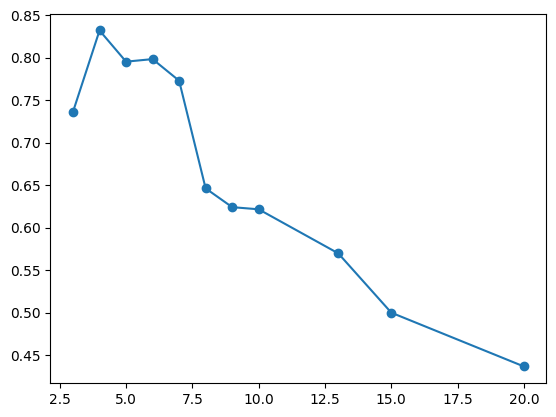

In [26]:
plt.plot(results["ps"], [results["postprocessing"][1][p][0]["r"] for p in results["ps"]], marker="o")